In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
from torch.distributions.categorical import Categorical

import pytorch_lightning as pl
from pytorch_lightning.metrics import functional
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
import scipy.stats as stats
from torchsummary import summary
from functools import partial

import boda
#from boda.generator.parameters import StraightThroughParameters
#from boda.generator import FastSeqProp, AdaLead
#from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm
from boda.model.mpra_basset import MPRA_Basset
from boda.data.mpra_datamodule import MPRA_DataModule
from boda.common import constants, utils
#from boda.generator.energy import BaseEnergy

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

# from main import unpack_artifact, model_fn
# from pymeme import streme, parse_streme_output

In [3]:
def get_truths_only(datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    if dataset=='val':
        data_generator = datamodule.val_dataloader()
    if dataset=='test':
        data_generator = datamodule.test_dataloader()
    if dataset=='chr_train':
        data_generator = datamodule.chr_train_dataloader()
    if dataset=='chr_val':
        data_generator = datamodule.chr_val_dataloader()
    if dataset=='chr_test':
        data_generator = datamodule.chr_test_dataloader()
    if dataset=='synth_train':
        data_generator = datamodule.synth_train_dataloader()
    if dataset=='synth_val':
        data_generator = datamodule.synth_val_dataloader()
    if dataset=='synth_test':
        data_generator = datamodule.synth_test_dataloader()

    truths = []
    for local_batch, local_targets in data_generator:
        truths.append(local_targets.numpy())
    truths_array = np.concatenate(truths, axis=0)
    #Unscale:
    if datamodule.rescale is not None:
        a, b = datamodule.rescale
        mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
        truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
    return truths_array

def get_predictions(model, datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    elif dataset=='val':
        data_generator = datamodule.val_dataloader()
    elif dataset=='test':
        data_generator = datamodule.test_dataloader()
    elif dataset=='chr_train':
        data_generator = datamodule.chr_train_dataloader()
    elif dataset=='chr_val':
        data_generator = datamodule.chr_val_dataloader()
    elif dataset=='chr_test':
        data_generator = datamodule.chr_test_dataloader()
    elif dataset=='synth_train':
        data_generator = datamodule.synth_train_dataloader()
    elif dataset=='synth_val':
        data_generator = datamodule.synth_val_dataloader()
    elif dataset=='synth_test':
        data_generator = datamodule.synth_test_dataloader()
    elif dataset=='extra':
        data_generator = datamodule.synth_test_dataloader()
    model.eval()
    truths = []
    preds = []
    if next(model.parameters()).is_cuda:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch.cuda()).cpu().detach().numpy())
            truths.append(local_targets.numpy())
    else:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch).detach().numpy())
            truths.append(local_targets.numpy())
    preds_array = np.concatenate(preds, axis=0)
    truths_array = np.concatenate(truths, axis=0)
    # #Unscale:
    # if datamodule.rescale is not None:
    #     a, b = datamodule.rescale
    #     mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
    #     truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
    #     preds_array = (preds_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
        preds_array = preds_array * stds + means
    return truths_array, preds_array

def get_scatterplots(truths_array, preds_array, specificity_fn, celltypes=['K562', 'HepG2', 'SKNSH']):
    fig = plt.figure(figsize=(25,6))
    pearsons = []
    spearmans = []
    num_figures = len(celltypes) + 1 
    for dim in range(num_figures - 1):
        plt.subplot(1, num_figures, dim+1)
        pearson = stats.pearsonr(truths_array[:,dim], preds_array[:,dim])[0]
        pearsons.append(pearson)
        spearman = stats.spearmanr(truths_array[:,dim], preds_array[:,dim])[0]
        spearmans.append(spearman)
        sns.scatterplot(x=truths_array[:,dim], y=preds_array[:,dim], color='C'+str(dim), alpha=0.1)
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        lim_min = min( (truths_array[:,dim]).min(), (preds_array[:,dim]).min() ) - 0.1
        lim_max = max( (truths_array[:,dim]).max(), (preds_array[:,dim]).max() ) + 0.1
        plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.title(f'{celltypes[dim]} | Spearman {round(spearman, 2)}, Pearson {round(pearson, 2)}')
    plt.subplot(1, num_figures, num_figures)
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6', alpha=0.1)
    lim_min = min( specificity_truths.min(), specificity_preds.min() ) - 0.1
    lim_max = max( specificity_truths.max(), specificity_preds.max() ) + 0.1
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
    #plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.draw()
    plt.draw()
    print('')
    print('----------------------------------------------')
    print(f'Pearsons: {pearsons}, average: {round(np.mean(pearsons), 2)}')
    print(f'Spearmans: {spearmans}, average: {round(np.mean(spearmans), 2)}')
    print('----------------------------------------------')

def get_specificity_corr(truths_array, preds_array, specificity_fn):
    fig = plt.figure(figsize=(6,6))
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6')
    lim_min = min( specificity_truths.min(), specificity_preds.min() ) - 0.1
    lim_max = max( specificity_truths.max(), specificity_preds.max() ) + 0.1
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
    #plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.draw()
    
def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float64), dim=1).numpy()
    shannon = np.sum(- p_c * np.log(p_c), axis=1)
    return shannon

def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def single_entropy_score(x, num_classes=3):
    p_c = nn.Softmax(dim=0)(x)
    shannon = torch.sum(- p_c * torch.log(p_c), axis=0)
    return 1 - shannon / np.log(num_classes)

In [4]:
%%time
datamodule = MPRA_DataModule(datafile_path='MPRA_ALL_v3.txt',
                             data_project=['BODA', 'UKBB', 'GTEX'],  #'BODA', 'UKBB', 'GTEX'
                             project_column='data_project',
                             sequence_column='nt_sequence',
                             activity_columns=['K562_mean', 'HepG2_mean', 'SKNSH_mean'],
                             val_chrs=['19','21','X'], #'17','19','21','X' | '11', '15', 'Y'
                             test_chrs =['7', '13'],  #'7', '13' | '4','12'
                             chr_column='chr',
                             std_multiple_cut=3.5,
                             up_cutoff_move=7.0,
                             synth_chr='synth',
                             synth_val_pct=0,
                             synth_test_pct=99.98,
                             synth_seed=0,
                             batch_size=1024,
                             padded_seq_len=600, 
                             num_workers=4,
                             normalize=False,
                             duplication_cutoff=1.4,
                             use_reverse_complements=True)

if not torch.cuda.is_available():
    datamodule.numWorkers = 8

datamodule.setup()

--------------------------------------------------

K562 | top cut value: 11.57, bottom cut value: -3.57
HepG2 | top cut value: 11.08, bottom cut value: -3.16
SKNSH | top cut value: 11.45, bottom cut value: -3.62

Number of examples discarded from top: 0
Number of examples discarded from bottom: 212

Number of examples available: 792429

--------------------------------------------------

Padding sequences...
Tokenizing sequences...
Creating train/val/test datasets...
--------------------------------------------------

Number of examples in train: 1562038 (197.12%)
Number of examples in val:   60890 (7.68%)
Number of examples in test:  79627 (10.05%)

Excluded from train: -910126 (-114.85)%
--------------------------------------------------
CPU times: user 3min 2s, sys: 12.5 s, total: 3min 15s
Wall time: 3min 13s


In [5]:
last_activation_fn = 'ReLU6'
extra_hidden_size = 250
seed = 12

#! gsutil cp gs://syrgoth/my-model.epoch_5-step_19885.pkl ./
pl.seed_everything(seed)
model = MPRA_Basset(basset_weights_path='my-model.epoch_5-step_19885.pkl',
                    extra_hidden_size = extra_hidden_size,
                    criterion='L1Loss', #'MSELoss', #'L1Loss', #'SmoothL1Loss',
                    last_activation=last_activation_fn,
                    sneaky_factor=2,
                    pretrained=True)

if torch.cuda.is_available():
    model.cuda()
num_gpus = torch.cuda.device_count()
summary(model, (4, 600))

Global seed set to 12


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     ConstantPad1d-1               [-1, 4, 618]               0
            Conv1d-2             [-1, 300, 600]          23,100
       BatchNorm1d-3             [-1, 300, 600]             600
        Conv1dNorm-4             [-1, 300, 600]               0
              ReLU-5             [-1, 300, 600]               0
         MaxPool1d-6             [-1, 300, 200]               0
     ConstantPad1d-7             [-1, 300, 210]               0
            Conv1d-8             [-1, 200, 200]         660,200
       BatchNorm1d-9             [-1, 200, 200]             400
       Conv1dNorm-10             [-1, 200, 200]               0
             ReLU-11             [-1, 200, 200]               0
        MaxPool1d-12              [-1, 200, 50]               0
    ConstantPad1d-13              [-1, 200, 56]               0
           Conv1d-14              [-1, 

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
#-------------------- Train only last layer ------------------------
model.basset_net.freeze()

model.epochs = 15
model.learning_rate = 0.05     #0.05
model.weight_decay = 1e-6      #1e-6
model.scheduler = True         #True
datamodule.batch_size = 2048   #1024

logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True)
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     logger=logger, callbacks=[lr_monitor], precision=16)

trainer.fit(model, datamodule)
trainer.test()


#------------------------ Train all layers ------------------------
model.basset_net.unfreeze()

model.epochs = 50
model.learning_rate = 1e-2   #1e-2
model.weight_decay = 1e-5    #1e-5
model.scheduler = False      #False
datamodule.batch_size = 2048  #1024

logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True) 
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     logger=logger, callbacks=[lr_monitor], precision=16) 

trainer.fit(model, datamodule)
trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | In sizes  | Out sizes
-----------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?         | ?        
1 | last_activation | ReLU6      | 0      | [1, 250]  | [1, 250] 
2 | basset_net      | Basset     | 4.9 M  | ?         | ?        
3 | output_1        | Sequential | 250 K  | [1, 1000] | [1, 1]   
4 | output_2        | Sequential | 250 K  | [1, 1000] | [1, 1]   
5 | output_3        | Sequential | 250 K  | [1, 1000] | [1, 1]   
-----------------------------------------------------------------------
751 K     Trainable params
4.9 M     Non-trainable params
5.6 M     Total params
22.411    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12


| Prediction correlation: 0.00578 | Specificity correlation: -0.00048 |
-----------------------------------------------------------------------


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69847 | Specificity correlation: 0.27679 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.45897 | Specificity correlation: 0.28730 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69557 | Specificity correlation: 0.28573 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.46447 | Specificity correlation: 0.30272 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70000 | Specificity correlation: 0.26457 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.46269 | Specificity correlation: 0.28272 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69861 | Specificity correlation: 0.29675 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69957 | Specificity correlation: 0.28718 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70023 | Specificity correlation: 0.29225 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.69897 | Specificity correlation: 0.30004 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70130 | Specificity correlation: 0.30465 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70024 | Specificity correlation: 0.29783 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70155 | Specificity correlation: 0.29551 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.70221 | Specificity correlation: 0.30351 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


| Prediction correlation: 0.70171 | Specificity correlation: 0.30465 |
----------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6026799082756042}
--------------------------------------------------------------------------------



  | Name            | Type       | Params | In sizes  | Out sizes
-----------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?         | ?        
1 | last_activation | ReLU6      | 0      | [1, 250]  | [1, 250] 
2 | basset_net      | Basset     | 4.9 M  | ?         | ?        
3 | output_1        | Sequential | 250 K  | [1, 1000] | [1, 1]   
4 | output_2        | Sequential | 250 K  | [1, 1000] | [1, 1]   
5 | output_3        | Sequential | 250 K  | [1, 1000] | [1, 1]   
-----------------------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.411    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12


| Prediction correlation: 0.66388 | Specificity correlation: 0.26462 |
----------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: RuntimeWarning: You are using `LearningRateMonitor` callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.55831 | Specificity correlation: 0.47913 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.49718 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.51175 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28677 | Specificity correlation: 0.54242 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28765 | Specificity correlation: 0.54461 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28700 | Specificity correlation: 0.55182 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55999 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54712 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.56302 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54861 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28838 | Specificity correlation: 0.57012 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54527 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57386 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57197 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57176 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57714 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55903 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.29085 | Specificity correlation: 0.57316 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58046 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.29107 | Specificity correlation: 0.57895 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.59291 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58979 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55989 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57590 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58197 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55616 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58569 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54773 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57657 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57937 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58729 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57648 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57629 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57929 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.59103 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57163 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57568 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.29044 | Specificity correlation: 0.56937 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.59687 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58265 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57805 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57984 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58825 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58033 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53490 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.57879 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.29206 | Specificity correlation: 0.57627 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55731 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.58026 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


| Prediction correlation: 0.00000 | Specificity correlation: 0.56328 |
----------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4083448648452759}
--------------------------------------------------------------------------------


[{'test_loss': 0.4083448648452759}]


----------------------------------------------
Pearsons: [0.9035385922796297, 0.8982443653447056, 0.8952916393371106], average: 0.9
Spearmans: [0.8375554343617851, 0.849752333666585, 0.8420267366085716], average: 0.84
----------------------------------------------

----------------------------------------------
Pearsons: [0.8868709424791478, 0.8764684369700021, 0.8774841910896649], average: 0.88
Spearmans: [0.7903195841264204, 0.8077554193422344, 0.80893592182489], average: 0.8
----------------------------------------------

----------------------------------------------
Pearsons: [0.8273917226542813, 0.8197533987043162, 0.813874213501336], average: 0.82
Spearmans: [0.7522705837537741, 0.7625367521359256, 0.7717053662288738], average: 0.76
----------------------------------------------


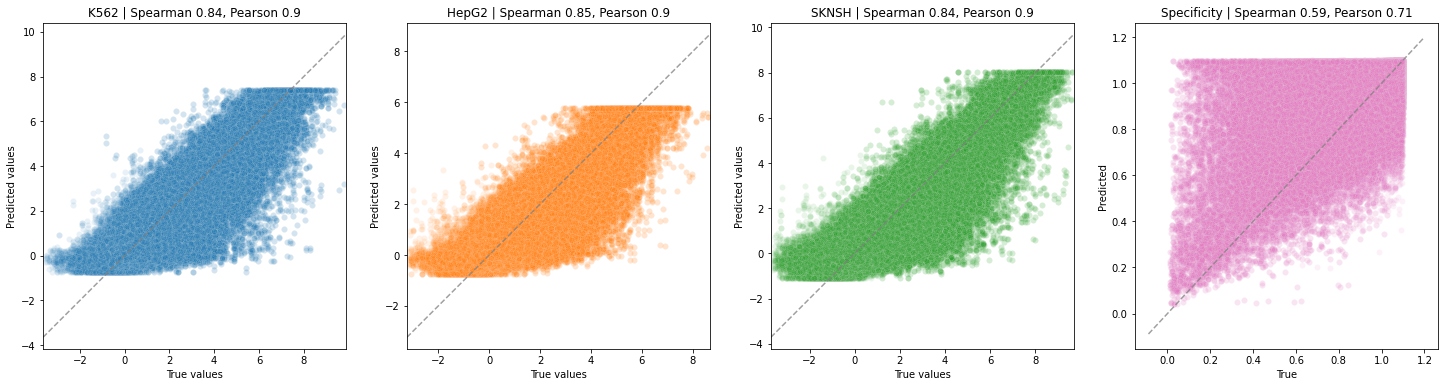

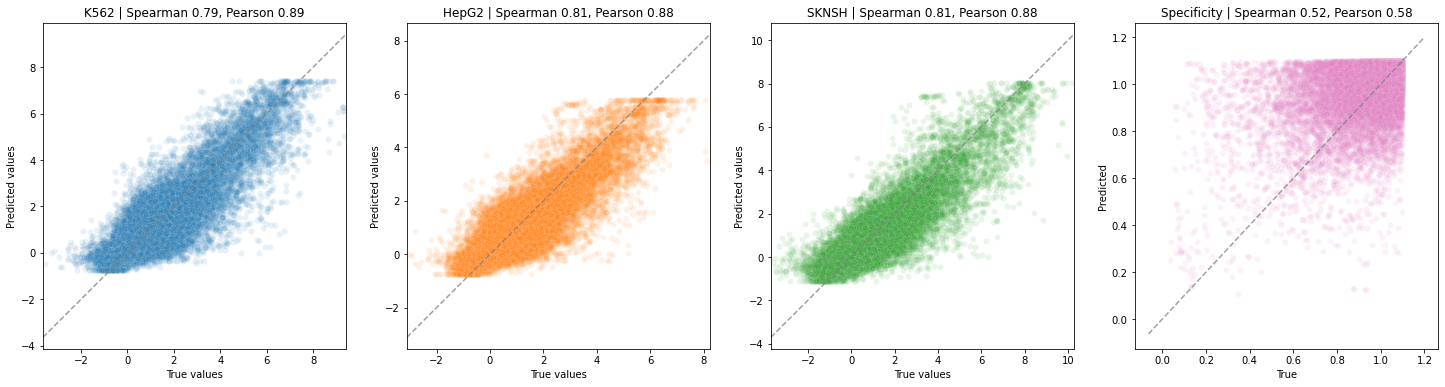

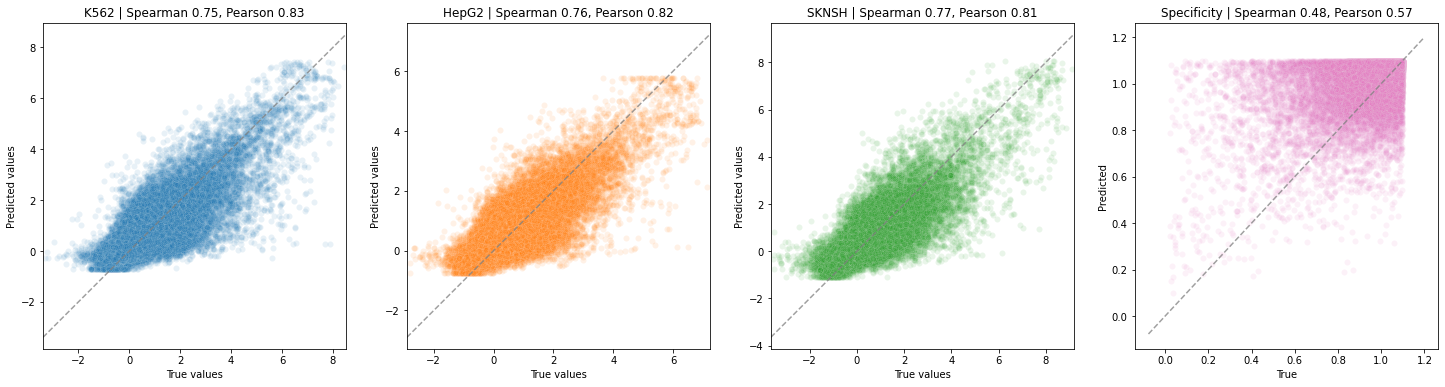

In [7]:
if not next(model.parameters()).is_cuda:
    model.cuda()

train_truths, train_preds = get_predictions(model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(model, datamodule, dataset='val')
test_truths, test_preds = get_predictions(model, datamodule, dataset='test')
get_scatterplots(train_truths, train_preds, specificity_fn=entropy)
get_scatterplots(val_truths, val_preds, specificity_fn=entropy)
get_scatterplots(test_truths, test_preds, specificity_fn=entropy)

In [8]:
#------------------------ Train all layers ------------------------
model.basset_net.unfreeze()

model.epochs = 3
model.learning_rate = 1e-3   #1e-2
model.weight_decay = 1e-5    #1e-5
model.scheduler = False      #False
datamodule.batch_size = 2048  #1024

logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True) 
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     logger=logger, callbacks=[lr_monitor], precision=16) 

trainer.fit(model, datamodule)
trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | In sizes  | Out sizes
-----------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?         | ?        
1 | last_activation | ReLU6      | 0      | [1, 250]  | [1, 250] 
2 | basset_net      | Basset     | 4.9 M  | ?         | ?        
3 | output_1        | Sequential | 250 K  | [1, 1000] | [1, 1]   
4 | output_2        | Sequential | 250 K  | [1, 1000] | [1, 1]   
5 | output_3        | Sequential | 250 K  | [1, 1000] | [1, 1]   
-----------------------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.411    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12


| Prediction correlation: 0.85094 | Specificity correlation: 0.57265 |
----------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: RuntimeWarning: You are using `LearningRateMonitor` callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.61267 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.61189 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.60713 |
----------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3848099112510681}
--------------------------------------------------------------------------------


[{'test_loss': 0.3848099112510681}]


----------------------------------------------
Pearsons: [0.9426362514308461, 0.9391577717511319, 0.9325663952265585], average: 0.94
Spearmans: [0.874500957453944, 0.8895233883297153, 0.8799516509029449], average: 0.88
----------------------------------------------

----------------------------------------------
Pearsons: [0.89671065299576, 0.8895266656930068, 0.8874410690665485], average: 0.89
Spearmans: [0.8097893910697517, 0.8294874305723575, 0.8269391077179863], average: 0.82
----------------------------------------------

----------------------------------------------
Pearsons: [0.8447914212713111, 0.8396258004141467, 0.8308183707078648], average: 0.84
Spearmans: [0.7769718330927983, 0.7863894958333465, 0.7913545405814051], average: 0.78
----------------------------------------------


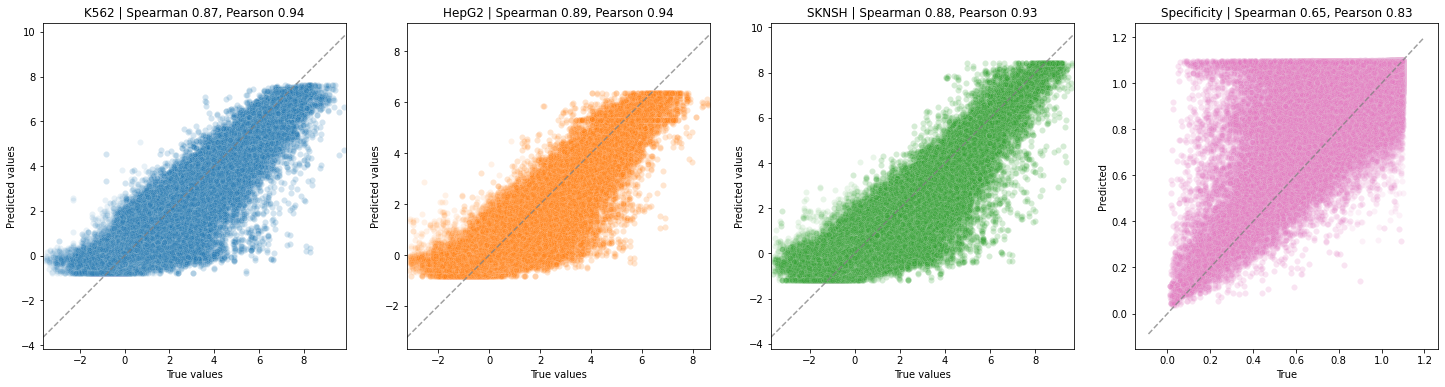

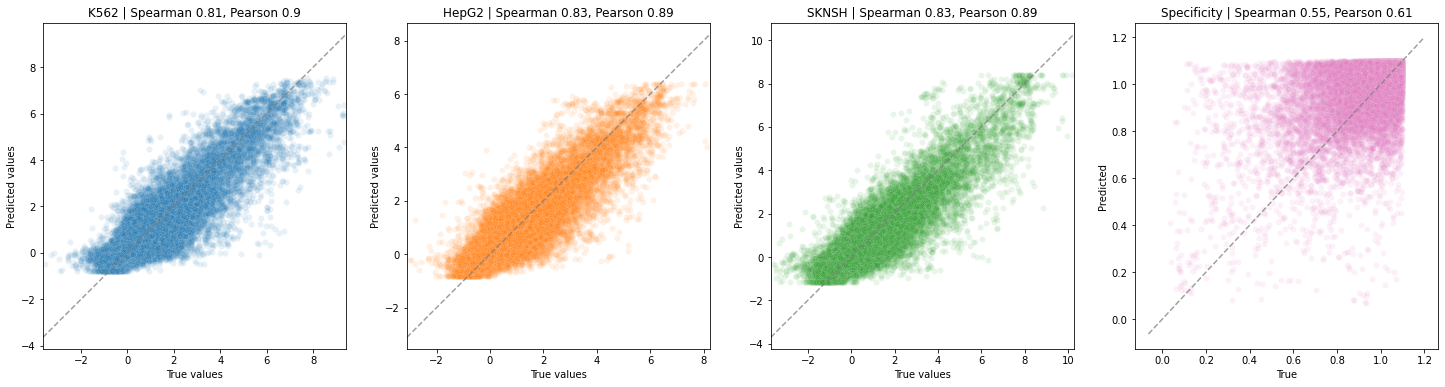

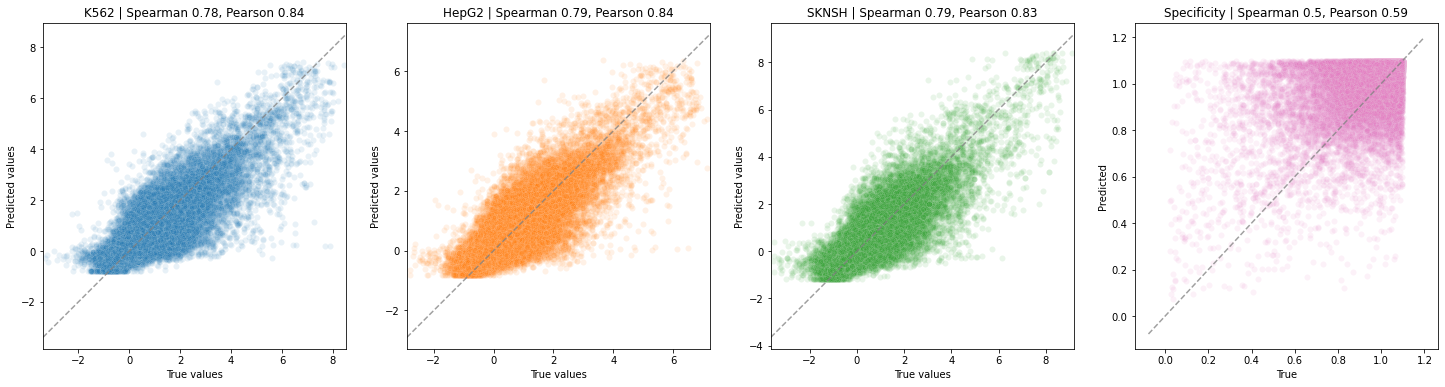

In [9]:
if not next(model.parameters()).is_cuda:
    model.cuda()

train_truths, train_preds = get_predictions(model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(model, datamodule, dataset='val')
test_truths, test_preds = get_predictions(model, datamodule, dataset='test')

get_scatterplots(train_truths, train_preds, specificity_fn=entropy)
get_scatterplots(val_truths, val_preds, specificity_fn=entropy)
get_scatterplots(test_truths, test_preds, specificity_fn=entropy)


----------------------------------------------
Pearsons: [0.8544915125748603, 0.8552741759092887, 0.8478851844095222], average: 0.85
Spearmans: [0.7734020888251172, 0.7971722219904155, 0.7977772177212716], average: 0.79
----------------------------------------------

----------------------------------------------
Pearsons: [0.8023372524820626, 0.793354226670767, 0.7736289303289128], average: 0.79
Spearmans: [0.7952227727861412, 0.7779413091443658, 0.7829249939719984], average: 0.79
----------------------------------------------


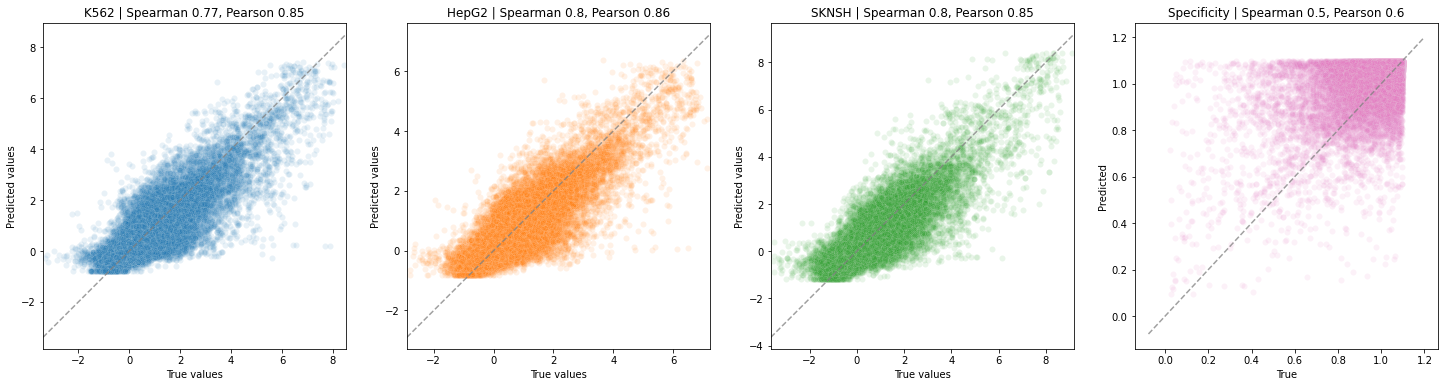

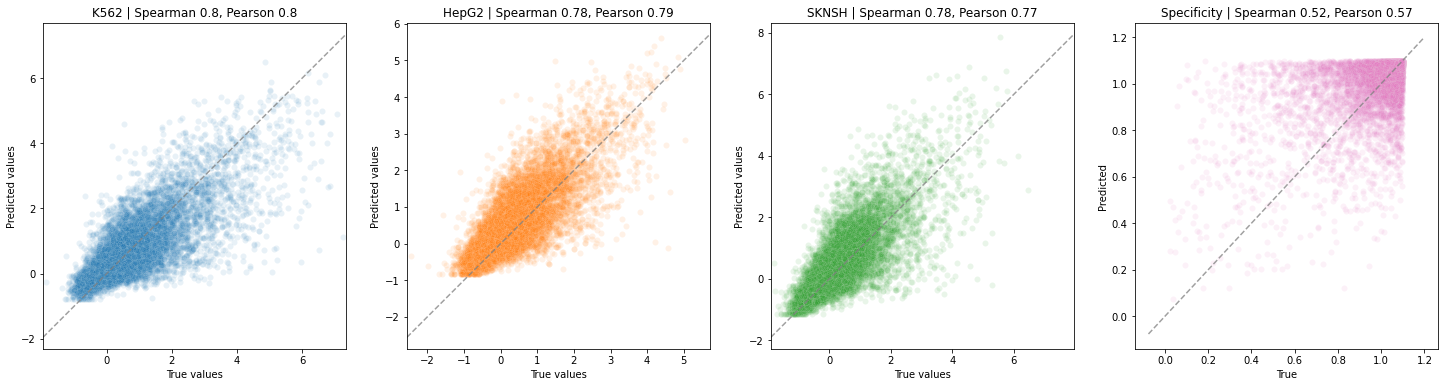

In [10]:
chr_test_truths, chr_test_preds = get_predictions(model, datamodule, dataset='chr_test')
synth_test_truths, synth_test_preds = get_predictions(model, datamodule, dataset='synth_test')
get_scatterplots(chr_test_truths, chr_test_preds, specificity_fn=entropy)
get_scatterplots(synth_test_truths, synth_test_preds, specificity_fn=entropy)